In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd
import sys, os
from pathlib import Path

# clustering libraries
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances

# plotting conveniences
plt.rc('text', usetex=True)
sns.set_style("ticks")
sns.set_context("paper",font_scale=2.0)
sns.set_style({"xtick.direction": "in","ytick.direction": "in"})

In [2]:
data_dir = Path('../data/')
ml_dir = data_dir / 'movie_lense'
netflix_dir = data_dir / 'netflix'

In [3]:
def calculate_inertias(points, kmax):
    inertias = []
    for k in range(1, kmax+1):
        kmeans = KMeans(n_clusters=k).fit(points)
        inertias.append(kmeans.inertia_)
    return inertias

## Movie -- Tag Matrix Clustering

In [4]:
genome_scores = pd.read_csv(ml_dir / 'genome-scores.csv')
genome_tags = pd.read_csv(ml_dir / 'genome-tags.csv')

In [5]:
# Let's start out by doing clustering and PCA on the movie genome data since
# we don't have to worry about sparseness
mat = pd.pivot_table(genome_scores, values='relevance', index='movieId', columns='tagId')
print('There are', mat.shape[0], 'movies and', mat.shape[1], 'tags')

There are 13176 movies and 1128 tags


In [6]:
# Standardize the data along each tag axis: both de-mean and unit variance

ss = StandardScaler(with_std=True)
ss.fit(mat)
mat = ss.transform(mat)

In [7]:
# start out by doing PCA and then plotting to see where the movies lie on the two principle component axes
pca = PCA(n_components=50)
pca.fit(mat)

PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

0.5842575483137251


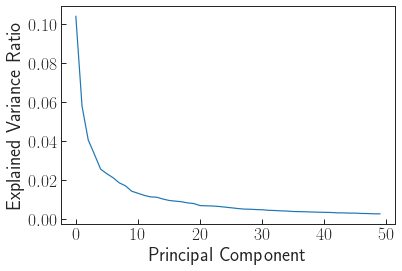

In [8]:
plt.plot(pca.explained_variance_ratio_)
plt.xlabel(r'Principal Component')
plt.ylabel(r'Explained Variance Ratio')
print(np.sum(pca.explained_variance_ratio_)) # First 50 components give 58% of variance

In [9]:
reduced_dat = pca.transform(mat)

Text(0, 0.5, 'PC2')

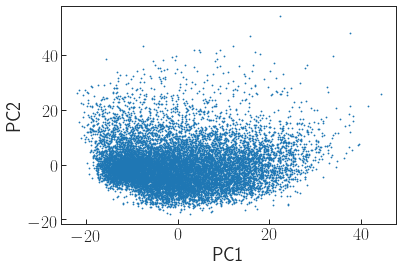

In [11]:
fig = plt.figure()
plt.scatter(reduced_dat[:,0], reduced_dat[:,1], s=1)
plt.xlabel(r'PC1')
plt.ylabel(r'PC2')

In [138]:
# t-SNE on reduced dataset, with 50 columns instead of ~1.2k tag columns

tsne = TSNE(n_components=2, perplexity=30, n_iter=5000)
mat_embedded = tsne.fit_transform(reduced_dat)

In [139]:
sse = calculate_inertias(reduced_dat, kmax=30)

Text(0, 0.5, 'Sum of squared errors')

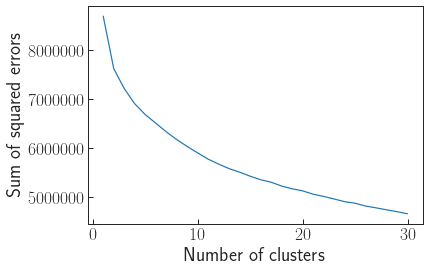

In [140]:
plt.plot(range(1,31), sse)
plt.xlabel(r'Number of clusters')
plt.ylabel(r'Sum of squared errors')
# There actually isn't much of an elbow in this

In [143]:
# Just try k-means with 10 clusters since there isn't much of an elbow

cluster = KMeans(n_clusters=10)
group_pred = cluster.fit_predict(reduced_dat)

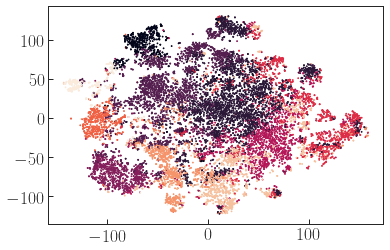

In [144]:
plt.scatter(mat_embedded[:,0], mat_embedded[:,1], s=1, c=group_pred)

## User -- Movie Matrix Clustering

This was the least successful of the various approaches so far. I used PyPPCA to impute the missing data on a subset of the user x movie matrix with users of over 1000 reviews and movies of over 1000 reviews. This matrix was 33 per cent filled. No noteworthy clusters were identified in t-SNE.

To Daming: Another idea could involve doing SVD to generate a dense matrix in order to cluster users.

In [5]:
ratings = pd.read_csv(ml_dir / 'ratings.csv')

In [6]:
print('There are %d unique movies' % ratings['movieId'].unique().shape[0]) # ~54k unique movies

There are 53889 unique movies


In [7]:
print('There are %d unique users' % ratings['userId'].unique().shape[0])  # 283k unique users!!

There are 283228 unique users


Text(0.5, 0, '$\\log_{10}($Number of ratings per movie$)$')

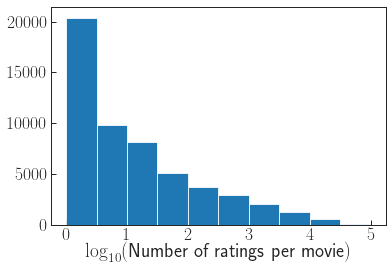

In [8]:
# Perhaps it may be of most interest to subsample on the movies and the users who rate the most so that we
# have a reduced dataset?

# Let's first look at histograms of the number of reviews per movie and number of reviews per user

n, bins, patches = plt.hist(np.log10(ratings.groupby('movieId')['movieId'].count()))
assert np.sum(n) == ratings['movieId'].unique().shape[0]

plt.xlabel(r'$\log_{10}($Number of ratings per movie$)$')

Text(0.5, 0, '$\\log_{10}($Number of ratings per user$)$')

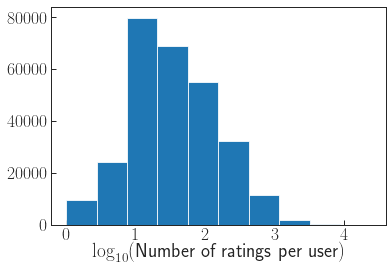

In [9]:
n, bins, patches = plt.hist(np.log10(ratings.groupby('userId')['userId'].count()))
assert np.sum(n) == ratings['userId'].unique().shape[0]

plt.xlabel(r'$\log_{10}($Number of ratings per user$)$')

In [10]:
ratings.shape
# 27m (!) ratings

(27753444, 4)

In [11]:
# Let's make a reasonable cut
# Movies with at least 500 reviews, users with at least 500 reviews

sub_ratings = ratings[ratings['movieId'].map(ratings['movieId'].value_counts()) >= 500]
sub_ratings = sub_ratings[sub_ratings['userId'].map(sub_ratings['userId'].value_counts()) >= 500]

In [12]:
sub_ratings.shape # now only 7.7m, down from 27m...

(7748230, 4)

In [13]:
# compute the sparseness now
n_movie = sub_ratings['movieId'].unique().shape[0]
n_user = sub_ratings['userId'].unique().shape[0]
total_reviews = len(sub_ratings)
completeness = total_reviews / (n_movie * n_user)
print(n_movie, n_user)
print("Fraction of matrix that is filled:", completeness)

5550 9239
0.1511069896609457


In [14]:
# Goal: take a subset of the data that is more complete, with movies that have a large number of ratings
# and users that have given a large number of ratings

# From this, perform clustering on users
from pyppca.pyppca import ppca

In [15]:
sub_ratings_mat = pd.pivot_table(sub_ratings, values='rating', index='userId', columns='movieId')

In [16]:
C, ss, M, X, Ye = ppca(sub_ratings_mat.values, 50, True)
# Ye is the sub_ratings (n_user x n_movie) matrix with probablistic PCA-based imputation

Objective: 53600056.90, Relative Change 1.00000
Objective: 51687933.10, Relative Change 0.03567
Objective: 50454259.74, Relative Change 0.02387
Objective: 49666538.15, Relative Change 0.01561
Objective: 49104746.28, Relative Change 0.01131
Objective: 48691628.57, Relative Change 0.00841
Objective: 48388187.05, Relative Change 0.00623
Objective: 48160559.56, Relative Change 0.00470
Objective: 47983642.39, Relative Change 0.00367
Objective: 47842035.70, Relative Change 0.00295
Objective: 47726372.69, Relative Change 0.00242
Objective: 47630542.84, Relative Change 0.00201
Objective: 47550256.85, Relative Change 0.00169
Objective: 47482347.59, Relative Change 0.00143
Objective: 47424405.77, Relative Change 0.00122
Objective: 47374565.30, Relative Change 0.00105
Objective: 47331362.96, Relative Change 0.00091
Objective: 47293640.70, Relative Change 0.00080
Objective: 47260474.90, Relative Change 0.00070
Objective: 47231123.76, Relative Change 0.00062
Objective: 47204987.67, Relative Change 

In [17]:
# De-mean the ratings for each movie... This is probably not ideal

ss = StandardScaler(with_std=False)
ss.fit(Ye)
Ye = ss.transform(Ye)

In [18]:
pca = PCA(n_components=50)
pca.fit(Ye)

PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

0.8037399612015675


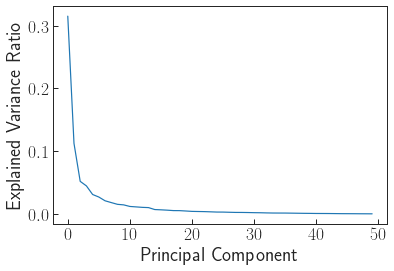

In [19]:
plt.plot(pca.explained_variance_ratio_)
plt.xlabel(r'Principal Component')
plt.ylabel(r'Explained Variance Ratio')
print(np.sum(pca.explained_variance_ratio_))

# 80 percent of variance explained, with much of it coming from only the first few PCs

In [20]:
# Run t-SNE on the n_user x 50 PCA-reduced dataset from the n_user x n_movie PPCA imputed data
tsne_user = TSNE(n_components=2, perplexity=30)
reduced_Ye = pca.transform(Ye)
Ye_embedded_user = tsne_user.fit_transform(reduced_Ye)

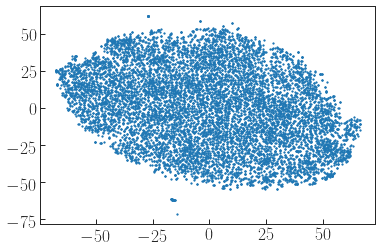

In [21]:
plt.scatter(Ye_embedded_user[:,0], Ye_embedded_user[:,1], s=2)

# No significant clusters seem to be present here

## User -- Tag Matrix Clustering

In [156]:
# Ideas for cuts on the data to make
# Eliminate users who have not rated many movies (done)
# Remove tags that aren't significant
# Remove all movies that aren't present in the genome (done)

In [157]:
ratings = pd.read_csv(ml_dir / 'ratings.csv')
genome_scores = pd.read_csv(ml_dir / 'genome-scores.csv')
print(ratings.shape, ratings['movieId'].unique().shape, ratings['userId'].unique().shape)

(27753444, 4) (53889,) (283228,)


In [158]:
ratings = ratings[ratings['movieId'].isin(genome_scores['movieId'].unique())]

In [159]:
print(ratings.shape, ratings['movieId'].unique().shape)

(27417362, 4) (13176,)


In [160]:
ratings = ratings[ratings['userId'].map(ratings['userId'].value_counts()) >= 500]

In [161]:
print(ratings.shape, ratings['movieId'].unique().shape, ratings['userId'].unique().shape)
# This cut drops us to 10k consumers from 283k
# Should still be enough to do clustering, but can always reduce the threshold on number of ratings

(9037545, 4) (13176,) (10132,)


In [163]:
genome_mat = pd.pivot_table(genome_scores, values='relevance', index='movieId', columns='tagId')

In [164]:
# For each unique consumer, we need to find all of their movie ratings and sum the relevant rows of the genome
# Admittedly not the most elegant way to wrangle this into shape, but it works
consumer_tag_mat = ratings.groupby('userId').apply(lambda x: (x['rating'].values - 3.5).dot(genome_mat.loc[x['movieId']]))

# Uncomment this below if you would rather not multiply by the rating-3.5 but just the raw rating
#consumer_tag_mat = ratings.groupby('userId').apply(lambda x: x['rating'].values.dot(genome_mat.loc[x['movieId']]))

In [165]:
# consumer_tag_mat is dimension n_consumer x n_tag, so should be 10132 x 1128 currently
consumer_tag_mat = np.concatenate(consumer_tag_mat.values).ravel().reshape((ratings['userId'].unique().shape[0], genome_mat.shape[1]))

In [166]:
consumer_tag_mat = pd.DataFrame(data=consumer_tag_mat, index=[i[0] for i in ratings.groupby('userId')['userId'].unique().values], columns=genome_mat.columns)
consumer_tag_mat.index.name = 'userId'

In [167]:
# We want each vector to have norm 1
# and if a rating is less than 3.5, it contributes negatively, otherwise it contributes positively
consumer_tag_mat = consumer_tag_mat.div(np.sqrt((consumer_tag_mat**2).sum(axis=1)), axis=0)

In [121]:
# for k-means and t-SNE
distance_matrix = pairwise_distances(consumer_tag_mat, consumer_tag_mat, metric='cosine', n_jobs=-1)

In [123]:
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, metric="precomputed")
dm_embedded = tsne.fit_transform(distance_matrix)

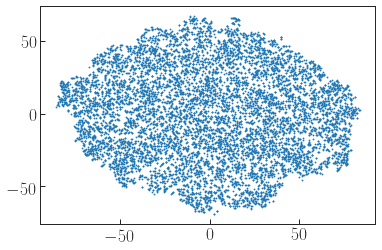

In [125]:
plt.scatter(dm_embedded[:,0], dm_embedded[:,1], s=1)

# When cosine distance is used and we don't subtract off some mean score to differentiate between good and
# bad, we just get a blob

In [168]:
consumer_tag_mat.mean(axis=0)
# Hasn't been de-meaned

tagId
1      -0.006409
2      -0.005078
3       0.002882
4       0.004092
5       0.007640
          ...   
1124    0.001069
1125    0.000491
1126    0.004930
1127   -0.011571
1128   -0.001409
Length: 1128, dtype: float64

0.8051048075355484


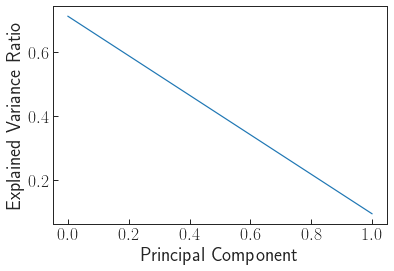

In [170]:
ss = StandardScaler(with_std=True)
ss.fit(consumer_tag_mat)
consumer_tag_mat_scaled = ss.transform(consumer_tag_mat)

# by scaling, we now make it so that the distribution in each tag simply represents the
# individual's preference for that tag relative to other users in a normalized fashion

pca = PCA(n_components=2)
pca.fit(consumer_tag_mat_scaled)
plt.plot(pca.explained_variance_ratio_)
plt.xlabel(r'Principal Component')
plt.ylabel(r'Explained Variance Ratio')
print(np.sum(pca.explained_variance_ratio_))

# Only need two PCs for 80% of variance explained (!)

(array([  2.,   6.,   9.,  16.,  32.,  78., 178., 269., 339., 199.]),
 array([0.01144713, 0.01381903, 0.01619092, 0.01856282, 0.02093471,
        0.02330661, 0.02567851, 0.0280504 , 0.0304223 , 0.0327942 ,
        0.03516609]),
 <a list of 10 Patch objects>)

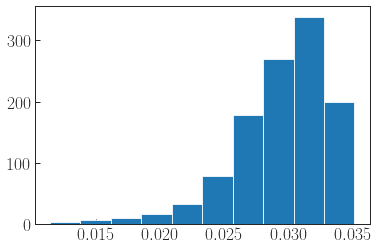

In [171]:
plt.hist(pca.components_[0])

Text(0, 0.5, 'PC2')

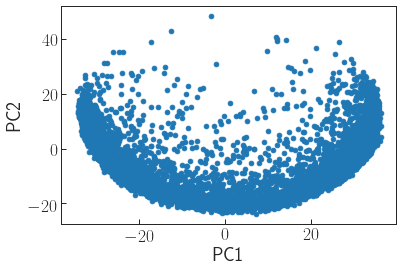

In [172]:
reduced_dat = pca.transform(consumer_tag_mat_scaled)
fig = plt.figure()
plt.scatter(reduced_dat[:,0], reduced_dat[:,1])
plt.xlabel(r'PC1')
plt.ylabel(r'PC2')

# Something strange happening here

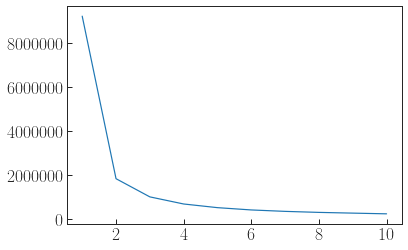

In [173]:
# Optimal number of clusters based on the 2-dimensional PC space
=inertia = calculate_inertias(reduced_dat, kmax=10)
plt.plot(range(1,11), inertia)

In [175]:
# Run t-SNE on the 2-dimensional PCA-reduced data n_user x 2
tsne = TSNE(n_components=2, perplexity=30, n_iter=5000)
reduced_dat_embedded = tsne.fit_transform(reduced_dat)

In [176]:
# 2 clusters based on elbow plot

cluster = KMeans(n_clusters=2)
group_pred = cluster.fit_predict(reduced_dat)

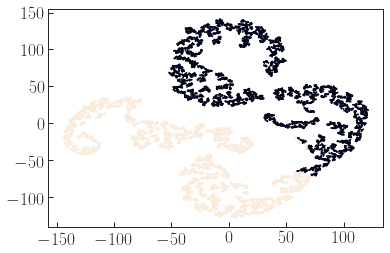

In [177]:
plt.scatter(reduced_dat_embedded[:,0], reduced_dat_embedded[:,1], s=1, c=group_pred)

# This one below is what we get if we subtract off 3.5 from the stars..

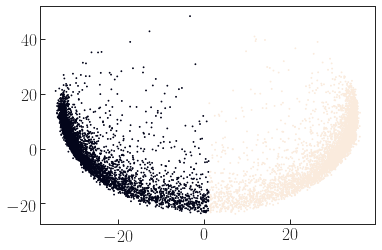

In [178]:
# This is just in the dim-2 PCA dimension projection again. Clearly the k-means just splits directly down the middle

fig = plt.figure()
plt.scatter(reduced_dat[:,0], reduced_dat[:,1], s=1, c=group_pred)

# This behavior is only present due to subtracting 3.5 from the stars
# Otherwise, it is just a blob

In [179]:
# Let's repeat the analysis on the full n_user x n_tag matrix instead of the PCA-reduced on

cluster = KMeans(n_clusters=5)
group_pred = cluster.fit_predict(consumer_tag_mat)

In [180]:
# Repeating t-SNE for full n_user x n_tag matrix

tsne = TSNE(n_components=2, perplexity=30, n_iter=5000)
consumer_tag_mat_embedded = tsne.fit_transform(consumer_tag_mat)

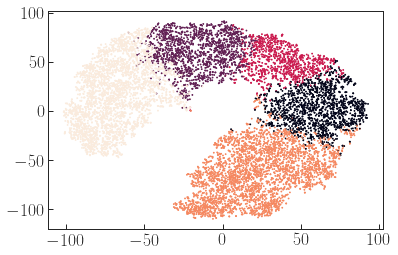

In [181]:
plt.scatter(consumer_tag_mat_embedded[:,0], consumer_tag_mat_embedded[:,1], s=1, c=group_pred)

In [ ]:
# Here's another configuration that runs PCA before t-SNE automatically

cluster2 = KMeans(n_clusters=5)
group_pred2 = cluster2.fit_predict(consumer_tag_mat_scaled)

tsne2 = TSNE(n_components=2, perplexity=30, n_iter=5000, init='pca')
consumer_tag_mat_embedded2 = tsne2.fit_transform(consumer_tag_mat_scaled)
plt.scatter(consumer_tag_mat_embedded2[:,0], consumer_tag_mat_embedded2[:,1], s=1, c=group_pred2)